# Clean Training Data based on Users

Initially, only hackers (users with unlikely many clicks and little picks) with 0 picks have been deleted. But training gets worse towards the end of each epoch - seems like data is not even.. 
Generally, hackers are defined as having more than 300.000 clicks and almost no picks. Delete top 20 Users based on amount of clicks from training data.

In [1]:
import pandas as pd

In [2]:
import sqlalchemy as db
from sqlalchemy import create_engine
import psycopg2

In [33]:
#DATABASE_URI = ###
#engine = create_engine(DATABASE_URI)
engine = sqlite3.connect('data/db.db')

## Hackers

In [4]:
hackers = pd.read_sql('''SELECT userid, count(datum_click) as clicks 
                      FROM target_training_enc 
                      GROUP BY userid ORDER BY clicks desc
                      limit 50 ''', engine)

In [6]:
hackers_top = hackers.userid.values.tolist()[:20]

In [7]:
hackers_top

['1559225',
 '1608456',
 '1657316',
 '1575782',
 '1587975',
 '463254',
 '1593360',
 '1604194',
 '1581399',
 '1613063',
 '1507515',
 '1528849',
 '1595551',
 '1613340',
 '1562316',
 '1576169',
 '890609',
 '902588',
 '1586355',
 '1531099']

## 1-Click Users

Since I use history to learn, all users with only 1 click do not provide any value in learning...

In [8]:
one_click = pd.read_sql('''SELECT userid, count(datum_click) as clicks 
                      FROM target_training_enc
                      GROUP BY userid ORDER BY clicks
                      limit 200000''', engine)

In [9]:
one = one_click[one_click.clicks == 1]

In [11]:
one_users = one.userid.values.tolist()

## Admins

internal users do not follow the habits of users - we click a lot but rarely pick, no value to model

In [12]:
admins = ['111',
'137',
'139',
'552',
'11001,'
'11002',
'11066',
'11072',
'48870',
'50076',
'51293',
'54241',
'65810',
'66389',
'87698',
'91405',
'92714',
'101601',
'128430',
'158834',
'177754',
'221429',
'274487',
'293829',
'329235',
'355828',
'355830',
'355831',
'429608',
'463254',
'589904',
'611108',
'645983',
'734608',
'779479',
'805744',
'830094',
'839528',
'897966',
'1515060',
'1515233',
'1560277',
'1564088',
'1567832',
'1567978',
'1572574',
'1576555',
'1578114',
'1581798',
'1581799',
'1586355',
'1647698',
'1662550',
'1671940',
'1683183',
'1691662',
'1694441',
'1695111',
'1696607']

## Suppliers

Suppliers are also do not have normal user behavior

In [13]:
vendor_df = pd.read_csv('data/training_data/vendorIDs.csv')

In [14]:
vendor_df

,User ID
0,276
1,321
2,392
3,30485
4,31944
...,...
190,1689523
191,1690761
192,1692926
193,1693783


In [15]:
vendors = vendor_df['User ID'].values.tolist()

In [16]:
vendorID = []
for i in range(len(vendors)):
    vendorID.append (str(vendors[i]))

## Combine all outliers

In [17]:
users_filter = hackers_top + one_users + admins + vendorID

In [18]:
users_filter

['1559225',
 '1608456',
 '1657316',
 '1575782',
 '1587975',
 '463254',
 '1593360',
 '1604194',
 '1581399',
 '1613063',
 '1507515',
 '1528849',
 '1595551',
 '1613340',
 '1562316',
 '1576169',
 '890609',
 '902588',
 '1586355',
 '1531099',
 '157809',
 '1570380',
 '1570384',
 '1578078',
 '1578077',
 '1570390',
 '1578074',
 '1578064',
 '1570403',
 '1578050',
 '1578044',
 '1628449',
 '1578012',
 '1503080',
 '1578006',
 '1577983',
 '1577971',
 '1570479',
 '1577944',
 '1577912',
 '1570498',
 '1570522',
 '1577904',
 '1570528',
 '1577884',
 '1577879',
 '1570551',
 '1577876',
 '1570559',
 '1627809',
 '1577828',
 '1570601',
 '1577792',
 '1577790',
 '1577754',
 '1570637',
 '1628440',
 '1577742',
 '1577731',
 '1628437',
 '1577721',
 '1570659',
 '1627820',
 '1577701',
 '1570686',
 '1577677',
 '1577665',
 '1577663',
 '1570706',
 '1570717',
 '1570733',
 '1570739',
 '1570767',
 '1570777',
 '1627829',
 '1570785',
 '1577600',
 '1577577',
 '1628430',
 '1570804',
 '1577567',
 '1577558',
 '1570811',
 '157081

In [19]:
len(users_filter)

19857

In [20]:
df = pd.DataFrame(users_filter)

In [21]:
df.columns = ["userid"]

In [22]:
df.drop_duplicates("userid", inplace = True)

In [23]:
len(df)

19849

In [24]:
df.head()

,UserID
0,1559225
1,1608456
2,1657316
3,1575782
4,1587975


### Save list of users to db

do not want to delete the data but rather filter it in training selection - therefore save all ids that are not normal user to db

In [30]:
meta = db.MetaData(engine)
user_filter = db.Table('training_user_filter', meta,
                 db.Column('userid', db.String, primary_key=True))
user_filter.create()

In [32]:
df.to_sql('training_user_filter', engine, index = False, if_exists = 'replace')

# Overview of current Data Set

Look at the distribution of users in current training data - is it weird? should I limit the number of training instances per user?

In [6]:
all_users = pd.read_sql('''SELECT userid, count(datum_click) as clicks 
                      FROM target_training_enc 
                      GROUP BY userid ORDER BY clicks desc''', engine)

The history saving thread hit an unexpected error (OperationalError('disk I/O error')).History will not be written to the database.


In [7]:
len(all_users)

137399

In [9]:
all_users.head()

,userID,clicks
0,1559225,252595
1,1608456,237458
2,1657316,180871
3,1575782,29301
4,1587975,22898


In [11]:
filter_users = pd.read_sql('''SELECT userid
                      FROM training_user_filter''', engine)

In [15]:
data1 = pd.merge(all_users, filter_users, how = 'left', left_on = "userid", right_on = "userid")

In [16]:
current_users = data1[pd.isna(data1['userid'])]

In [17]:
len(current_users)

117640

In [24]:
current_users.head()

,userID,clicks,UserID
20,864754,11051,NaN
21,566204,10974,NaN
22,1550835,10730,NaN
23,888020,10354,NaN
24,894451,10177,NaN


Distribution is very uneven between users

In [36]:
current_users.describe()

,clicks
count,117640.000000
mean,86.816780
std,340.838206
min,2.000000
25%,4.000000
50%,13.000000
75%,45.000000
max,11051.000000


### Users with more than 200 clicks

In [69]:
many_clicks = current_users[current_users['clicks'] > 1000]

In [70]:
len(many_clicks)

1858

In [71]:
many_clicks.clicks.sum()

3987661

In [75]:
view_clicks = current_users[current_users['clicks'] <= 1000]

In [76]:
len(view_clicks)

115782

In [77]:
view_clicks.clicks.sum()

6225465

75% of User are only represented in 10% of the data - could lead to overfitting the model to the 25% "heavy users", but we hope to transfer the trends and pattern that these users show to other users, no need in filtering out clicks! 

### Plot

In [8]:
from matplotlib import pyplot as plt

In [49]:
sub = current_users.sample(500).sort_values("clicks", ascending = False)

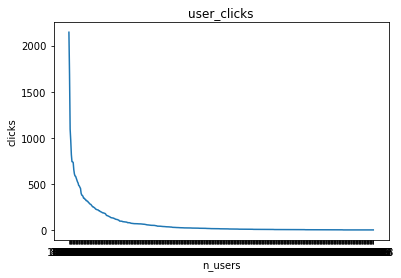

In [50]:
plt.plot(sub['userid'], sub['clicks'])
#plt.plot(val_loss)
plt.title('user_clicks')
plt.ylabel('clicks')
plt.xlabel('n_users')
#plt.legend(['train', 'validation'], loc='upper left')
plt.show()